# Setup

## Installs

In [1]:
# Segmentation
# ! pip install --upgrade mxnet
# ! pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install --upgrade gluoncv

In [2]:
# Edge detection
# ! conda install scikit-image

In [3]:
# Depth estimation
# ! pip install -q transformers

## Imports

In [4]:
# Segmentation
import numpy as np

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils.viz import get_color_pallete
from gluoncv.data.transforms.presets.segmentation import test_transform

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as pil

# using cpu
ctx = mx.cpu(0)

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.6.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [5]:
# Edge detection
from skimage.feature import canny
from matplotlib import cm

In [6]:
# Depth estimation
from transformers import pipeline
import requests
import cv2

# Read and Transform File

In [7]:
filename = 'images/inputs/rooms/empty-room.png'

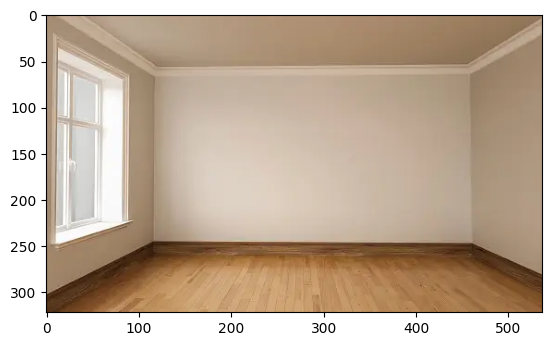

In [8]:
img = image.imread(filename)
plt.imshow(img.asnumpy())
plt.show()

In [9]:
img_t = test_transform(img, ctx)
img_t.shape

(1, 3, 322, 537)

# Semantic Segmentation

In [10]:
semantic_seg_model_psp = model = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=True)
semantic_seg_model_deeplab = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)
semantic_seg_model_fcn = gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True)

self.crop_size 480


In [11]:
output = semantic_seg_model_psp.predict(img_t)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'ade20k')
mask.save('images/outputs/segmentation-output.png')

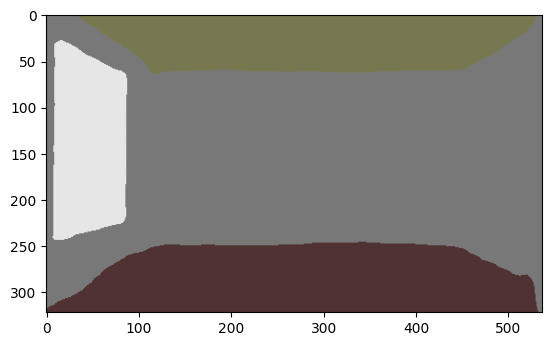

In [12]:
mmask = mpimg.imread('images/outputs/segmentation-output.png')
plt.imshow(mmask)
plt.show()

### Isolate walls

In [13]:
labs = []

for i in range(mmask.shape[0]):
    row = []
    for j in range(mmask.shape[1]):
        row.append(",".join(mmask[i, j].astype(str)))
    labs.append(row)

labs = np.array(labs)
labs.shape

(322, 537)

In [14]:
ind_0, ind_1 = np.where(labs != "0.47058824,0.47058824,0.47058824,1.0")
ind_2, ind_3 = np.where(labs == "0.47058824,0.47058824,0.47058824,1.0")

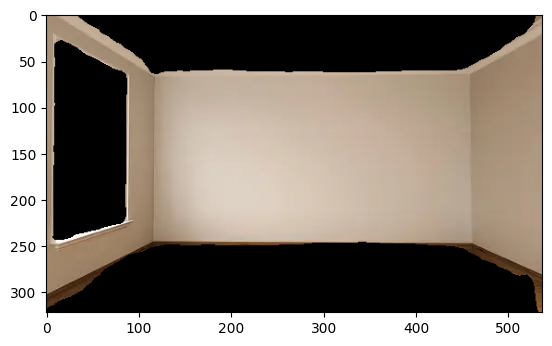

In [15]:
img2 = img.copy().asnumpy()
img2 = img2.astype(float)
img2[ind_0, ind_1] = np.array([0, 0, 0], dtype=float)
img2 = np.clip(img2, 0, 255)
segmented_img = pil.fromarray(img2.astype(np.uint8))
# img2 = img2.reshape((3, img2.shape[2], img2.shape[3]))
# img2 = img2.swapaxes(0, 1)
# img2 = img2.swapaxes(1, 2)
# print(img2.shape)

segmented_img.save('images/outputs/segmentation-walls-only.png')

plt.imshow(segmented_img)
plt.show()



# Depth Estimation

In [16]:
checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


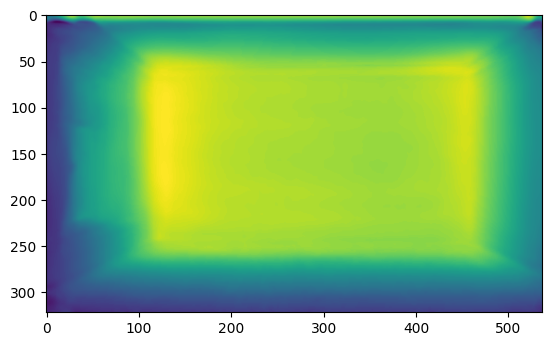

In [17]:
srcImage = pil.open(filename)
predictions = depth_estimator(srcImage)
depth_image = predictions["depth"]
# depth_image.save('images/outputs/depth-output.png')
plt.imsave('images/outputs/depth-output.png', depth_image)
plt.imshow(depth_image)
plt.show()

# Combining Images

In [18]:
# # Make depth map more contrasted
# from PIL import ImageEnhance
# new_img = ImageEnhance.Contrast(depth_image).enhance(2.5)
# new_img.save('images/outputs/depth-output.png')
# plt.imshow(new_img)

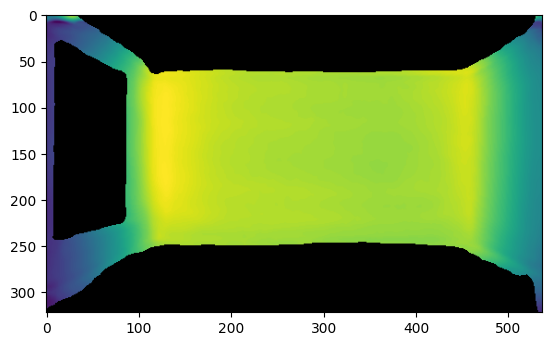

In [19]:
# Combine depth map and segmentation map
test = plt.imread('images/outputs/depth-output.png')[:, :, :3] * 255
# test = np.asarray(new_img.convert('RGB'))
segmented_depth = np.empty( (test.shape[0], test.shape[1], 3) )
segmented_depth[:] = np.nan
segmented_depth[ind_2, ind_3] = test[ind_2, ind_3]
segmented_depth = segmented_depth.astype(dtype=np.uint8)
plt.imshow(segmented_depth)

### Depth change to find corners

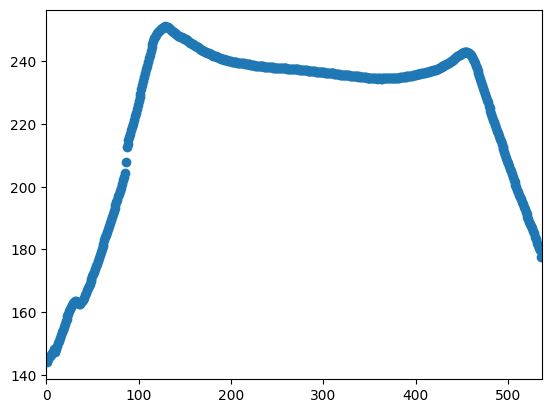

In [20]:
# # Find the mean depth for each column (1px wide) in the wall depth map and plot

test_depth = np.array(depth_image).copy().astype(float)
test_depth[ind_0, ind_1] = np.nan

y = np.nanmean(test_depth, axis=0)
x = range(len(y))

f, ax = plt.subplots(1)
ax.scatter(x, y)
ax.set_xlim(left=0)
ax.set_xlim(right=len(y))
plt.show(f)

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


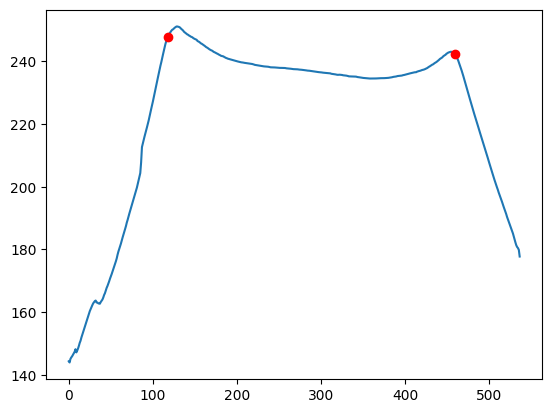

In [21]:
# https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals

from matplotlib import gridspec
from scipy.signal import savgol_filter, argrelmax
from scipy.ndimage.filters import gaussian_filter1d

gs = gridspec.GridSpec(5, 1) 

from scipy.signal import savgol_filter
window = 55
der2 = savgol_filter(y, window_length=window, polyorder=2, deriv=2)
max_der2 = np.max(np.abs(der2))
large = np.where(np.abs(der2) > max_der2/2)[0]
gaps = np.diff(large) > window
begins = np.insert(large[1:][gaps], 0, large[0])
ends = np.append(large[:-1][gaps], large[-1])
changes = ((begins+ends)/2).astype(np.int)
plt.plot(y)
plt.plot(changes, y[changes], 'ro')
plt.show()


##### Difference between predicted and actual depth

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


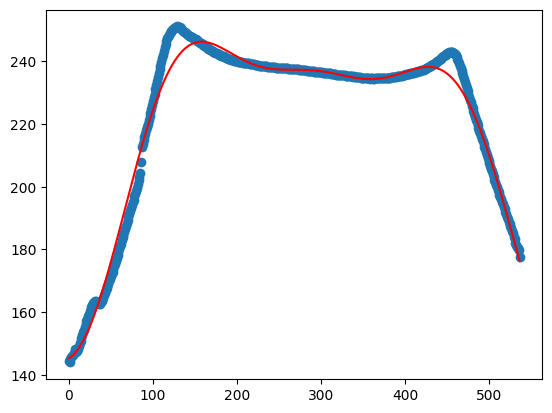

In [22]:
from sklearn.svm import SVR

test_depth = np.array(depth_image).copy().astype(float)
test_depth[ind_0, ind_1] = np.nan
y = np.nanmean(test_depth, axis=0)

# y = test_depth.copy()
x = range(len(y))
plt.scatter(x, y)

clf = SVR(kernel="rbf", C=100).fit(np.array(x).reshape(-1, 1),
                                       np.array(y).reshape(-1, 1))
plt.plot(x, clf.predict(np.array(x).reshape(-1, 1)), color="r")

from sklearn.preprocessing import StandardScaler

preds = clf.predict(np.array(x).reshape(-1, 1)).reshape(-1)
t2 = y.copy().reshape(-1)
z_score_pred_diff = StandardScaler().fit_transform((preds-t2).reshape(-1, 1)).reshape(-1)

##### Getting angles

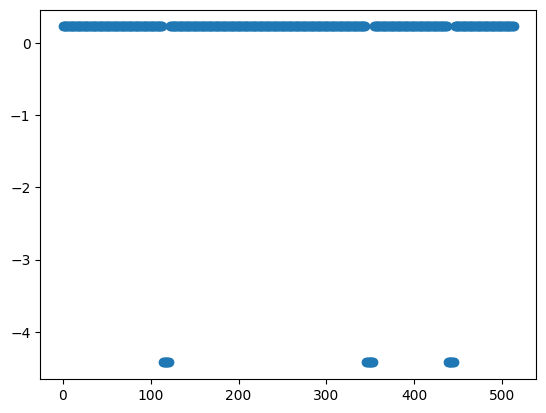

In [23]:
y = np.nanmean(test_depth, axis=0)
# y = test_depth.copy()
rolling_angle = []

for i in range(len(y)-23):
    t1 = y[i:i+10]
    t2 = y[i+10:i+15]
    t3 = y[i+15:i+25]
    
    t1_m = np.mean(t1)
    t2_m = np.mean(t2)
    t3_m = np.mean(t3)
    
    ba = t1_m - t2_m
    bc = t3_m - t2_m

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    # plt.plot([0, 1, 2], [np.mean(t1), t2, np.mean(t3)])
    # print(angle)
    # break
    
    rolling_angle.append(angle)
     
r_angle_z_score = StandardScaler().fit_transform(np.array(rolling_angle).reshape(-1, 1)).reshape(-1)
plt.scatter(range(len(r_angle_z_score)),r_angle_z_score)

##### Combining angles and prediction difference

537
16


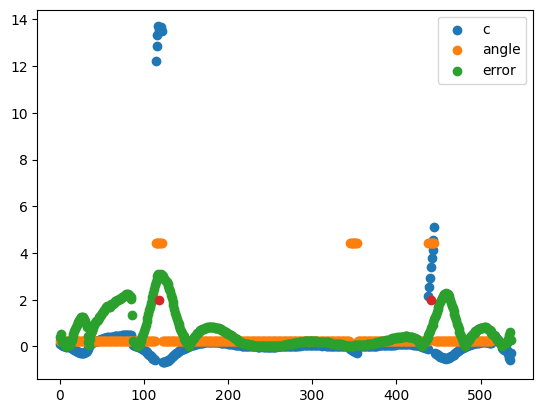

In [44]:
c = z_score_pred_diff.copy()
c[:len(r_angle_z_score)-len(z_score_pred_diff)] *= r_angle_z_score
plt.scatter(range(len(c)),c, label='c')
plt.scatter(range(len(r_angle_z_score)), np.abs(r_angle_z_score), label='angle')
plt.scatter(range(len(z_score_pred_diff)), np.abs(z_score_pred_diff), label='error')
plt.legend()
# plt.show()

c1 = c.copy() > 2
c1[c1] = c[c1]

# plt.scatter(range(len(c1)), c1)
# plt.show()
print(len(c1))

c2 = np.where(c1 == 1)[0]
print(len(c2))


# I used clustering to find the two distinct corner points (currently hard set to look for 2 clusters)
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=2).fit(c2.reshape(-1, 1))
plt.scatter(clf.cluster_centers_, [2, 2])

##### Combining angles and prediction difference

[118 442]


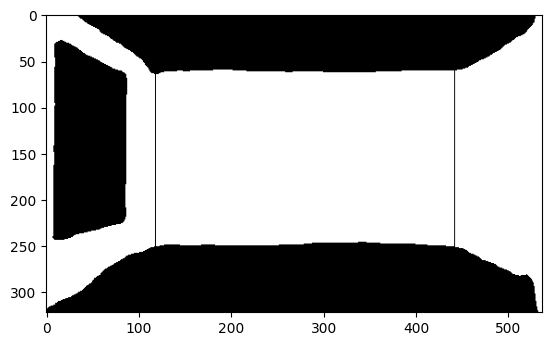

In [25]:
only_walls = np.array(segmented_img.copy())
only_walls[ind_0, ind_1] = [0, 0, 0]
only_walls[ind_2, ind_3] = [255, 255, 255]

corner_inds = np.round(np.ravel(clf.cluster_centers_), 0).astype(int)
only_walls[:, corner_inds] = [0, 0, 0]
print(corner_inds)

plt.imshow(only_walls)

In [26]:
pil_image = pil.fromarray(only_walls)
pil_image.save("images/outputs/segmented-with-corners.png")

## Harris corner detection

In [27]:
y_round = np.round(y.copy(), 0).astype(int)
y_round = y_round - np.amin(y_round)
matrix = np.zeros((np.amax(y_round)+1, len(x), 3))

for i in range(len(x)):
    matrix[y_round[i], i] = [255, 255, 255]

matrix = matrix.astype(np.uint8)

matrix = pil.fromarray(matrix)
matrix.save("images/outputs/matrix-test.png")

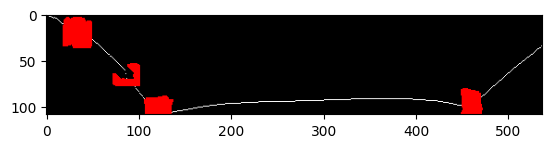

In [28]:
# Use cv2 method to detect 'corners'

image = cv2.imread('images/outputs/matrix-test.png')
image
operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  
# modify the data type 
# setting to 32-bit floating point 
operatedImage = np.float32(operatedImage) 
  
# apply the cv2.cornerHarris method 
# to detect the corners with appropriate 
# values as input parameters 
# dest = cv2.cornerHarris(operatedImage, 50, 29, 0.24)
dest = cv2.cornerHarris(operatedImage, 30, 5, 0.07)
  
# Results are marked through the dilated corners 
dest = cv2.dilate(dest, None) 
  
# Reverting back to the original image, 
# with optimal threshold value 
image[dest > 0.01 * dest.max()]=[255, 0, 0]



image = pil.fromarray(image.astype(np.uint8))
image.save("images/outputs/corners.png")
plt.imshow(image)

In [29]:
# corners = mpimg.imread('images/outputs/corners.png')
corners = plt.imread('images/outputs/corners.png')[:, :, :3] * 255

colours = []

for i in range(corners.shape[0]):
    row = []
    for j in range(corners.shape[1]):
        row.append(",".join(corners[i, j].astype(str)))
    colours.append(row)

colours = np.array(colours)


In [30]:
# Find indices where there is red
ind_x, ind_y = np.where(colours == "255.0,0.0,0.0")
# Round numbers to nearest 10 and then take only unique ones
ind_y = np.round(ind_y, -1)
ind_y = np.unique(ind_y)

first_range = 0
new_list = []

# If numbers are within 50 of eachother, only keep one of them
for n in ind_y:
    if n - first_range <= 50:
        pass
    else:
        new_list = np.append(new_list, n)
        first_range = n

new_list = new_list.astype(int)
print(new_list)

[ 70 130 450]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


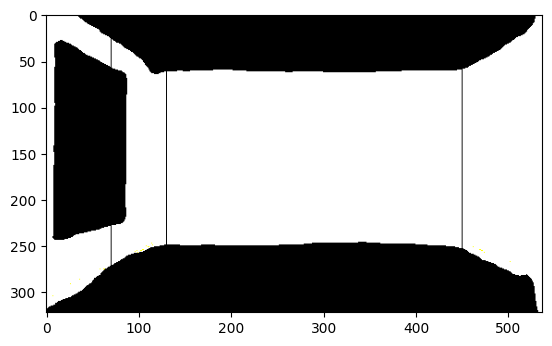

In [31]:
wall_segments = np.asarray(segmented_img.convert('RGB'))
wall_segments = wall_segments.astype(float)
wall_segments[:, new_list] = np.array([0, 0, 0], dtype=float)

plt.imshow(wall_segments)

## Finding Geometry

##### Extracting Geometry

In [32]:

im = cv2.imread('images/outputs/segmented-with-corners.png')
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 1, 0)

# thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


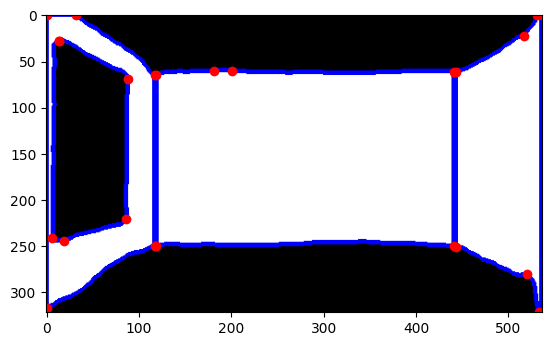

In [33]:
im_2 = im.copy()
final_cnt = []

for cnt in contours:
    x1,y1 = cnt[0][0]
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), False)

    # cv.putText(im_2, 'Rectangle', (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    im_2 = cv2.drawContours(im_2, [cnt], -1, (0,0,255), 3)
    plt.scatter(approx[:, 0, 0], approx[:, 0, 1], color="r")
    final_cnt.append(approx[:, 0, :])
    
plt.imshow(im_2)
final_cnt = np.array(final_cnt)

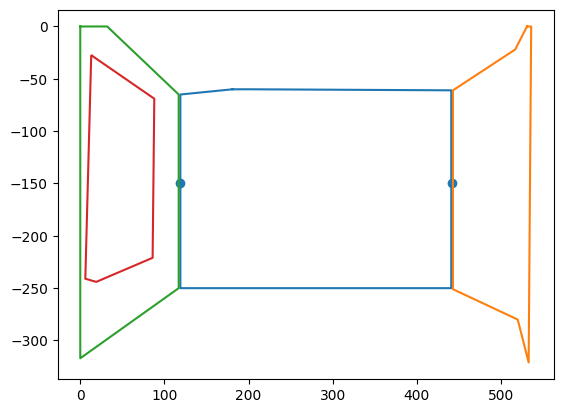

In [34]:
for i in range(len(final_cnt)):
    data = np.append(final_cnt[i], final_cnt[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])
    
plt.scatter(corner_inds, [-150, -150])

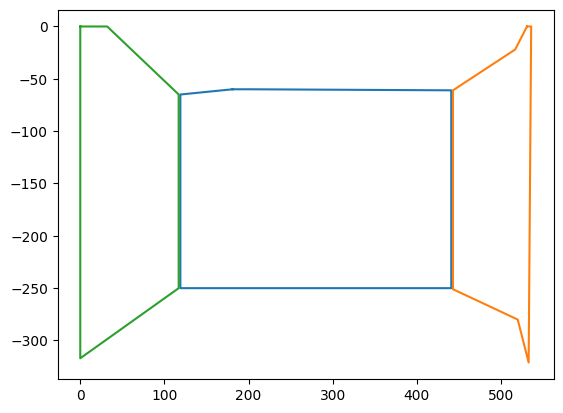

In [35]:
# Keep only shapes which have two points on the corner wall

corner_adj_geom = []

for i in range(len(final_cnt)):
    data = np.array(final_cnt[i])[:, 0]
    limit = 5
    
    diff_1 = np.sum(np.abs(data.copy() - corner_inds[0]) <= limit)
    diff_2 = np.sum(np.abs(data.copy() - corner_inds[1]) <= limit)
    
    if diff_1 >= 2 or diff_2 >= 2:
        corner_adj_geom.append(final_cnt[i])
        
for i in range(len(corner_adj_geom)):
    data = np.append(corner_adj_geom[i], corner_adj_geom[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

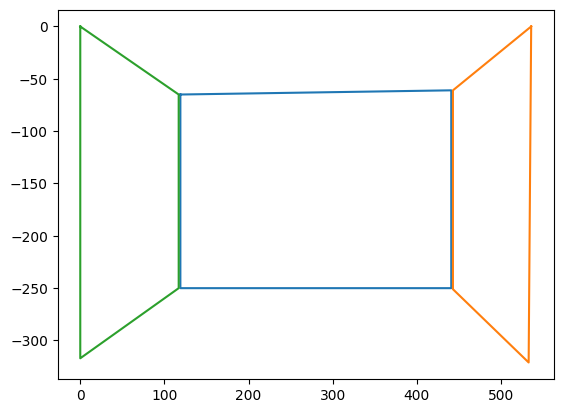

In [36]:
new_geom = []

# for each shape
for i in range(len(corner_adj_geom)):
    # try multiple thresholds
    for j in np.linspace(0.01, 0.1):
        # calc the polygon
        approx = cv2.approxPolyDP(corner_adj_geom[i], j*cv2.arcLength(corner_adj_geom[i], True), True)
        # if polygon has length of 4, keep it and break loop
        if len(approx) == 4:
            new_geom.append(approx)
            break

for i in range(len(new_geom)):
    data = np.append(new_geom[i], new_geom[i][0]).reshape(-1, 2)
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

## Perspective Transformation

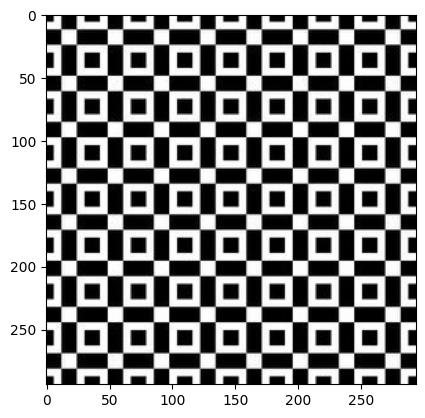

In [37]:
wallpaper = cv2.imread('images/inputs/wallpaper/squares.jpg')

plt.imshow(wallpaper)

### Transform wallpaper pattern

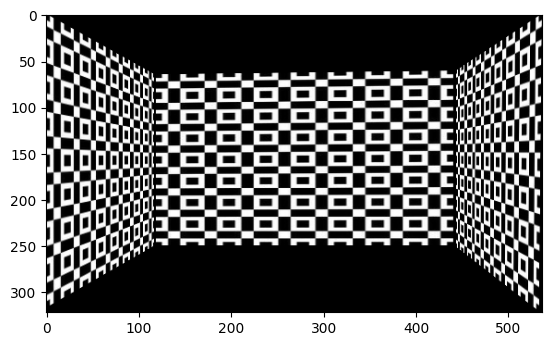

In [38]:
# find coordinates of corners of wallpaper image
shape = wallpaper.shape
corners = np.float32([[0,0], [0, shape[0]], [shape[1], shape[0]], [shape[1],0]])

# get size of output image
og = np.asarray(pil.open(filename))
size = (og.shape[1], og.shape[0])

walls = []

for wall in range(len(new_geom)):
    wall_coords = np.float32(new_geom[wall])

    matrix = cv2.getPerspectiveTransform(corners, wall_coords)
    result = cv2.warpPerspective(wallpaper, matrix, size)

    walls.append(result)

result = np.sum(walls, axis=0)

plt.imshow(result)

### Combine transformed wallpaper with original image

In [39]:
# new wall indices


result_new = np.array(og).copy()
geom_mask = []

for contour in new_geom:
    single_contour_mask = []
    for i in range(og.shape[0]):
        row = []
        for j in range(og.shape[1]):
            t = cv2.pointPolygonTest(contour, tuple([j, i]), False)
            if t in [1, 0]:
                row.append(1)
            else:
                row.append(0)      
        single_contour_mask.append(row)
    single_contour_mask = np.array(single_contour_mask)
    geom_mask.append(single_contour_mask)


geom_mask = np.amax(geom_mask, axis=0)


In [40]:
wall_mask = np.zeros([og.shape[0], og.shape[1]])
wall_mask[ind_2, ind_3] = 1


final_mask = np.zeros([og.shape[0], og.shape[1]])

for i in range(og.shape[0]):
    for j in range(og.shape[1]):
        if wall_mask[i,j] + geom_mask[i,j] == 2:
            final_mask[i,j] = 1 


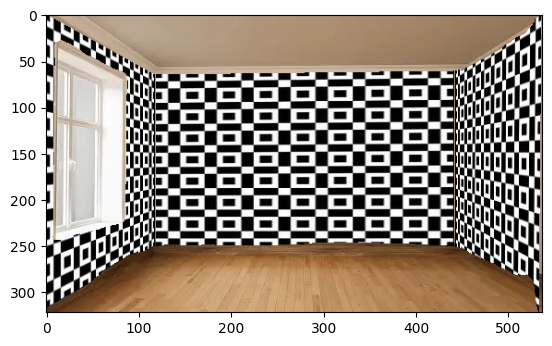

In [41]:
result_new = np.array(og).copy()
mask_ind_0, mask_ind_1 = np.where(final_mask == 1)
result_new[mask_ind_0, mask_ind_1] = result[mask_ind_0, mask_ind_1]
plt.imshow(result_new)